In [1]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
from typing import Dict, List, Union, Callable, Tuple
import hashlib
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from random import randrange
import seaborn as sns
from collections import deque
import torch.nn as nn
import torch
from torch import tensor
import torch.optim as optim
import torch.nn.functional as F

Utility functions used for both Approaches (DQN and Tabular Q-learning).

We implemented a set of utility functions that will be used in the RL training procedure. Specifically:

1. A `logger` function that prints the outcome of the game. 
2. A `convert_value_to_play_character` function that displays the value on empty positions and characters on utilized positions.
3. A `choose_players` function that will be used to switch the first player to start to play at every episode.
4. A `plot_rewards` function that plot the averaged rewards in a default window of $250$ games.    
5. A `plot_metrics` function that plot the $M_{opt}$ (optimal metric) and the $M_{rand}$ (random metric).
6. A `plot_epsilon` function that plot the evolution of epsilon with number of episodes for number of exploratory games.
7. A `plot_loss` function that plot the average training loss of the DQN Network with number of episodes.  

In [2]:
def logger(winner, player_1, player_2):
    # Logs the information if specified
    print('-------------------------------------------')
    print(f'Game end, winner is player {str(winner)}')
    print(f'Optimal player 1 = {str(player_1)}')
    print(f'RL Agent player 2 = {str(player_2)}')


def set_seed():
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)  
    return

def choose_players(index):
    if index%2 == 0:
        player_1 = 'X'
        player_2 = 'O'
    else:
        player_1 = 'O'
        player_2 = 'X' 
        
    return player_1,player_2 

def convert_value_to_play_character(state: np.ndarray, q_values):
    representation: List[List[str]] = [] 
    line: List[str] = [] 
    state = state.flatten()

    for start in range(0, 9, 3):
        line = []
        for index in range(start, start+3):
            if state[index] == 0:
                line.append(f"{round(float(q_values[index]) ,3)}")
            elif state[index] == 1:
                line.append("X")
            elif state[index] == -1:
                line.append("O")
        representation.append(line)
    representation = np.array(representation)
    return representation
    
def plot_rewards(number_of_episodes, rewards, ax, label = "", plot_every=250):
    episodes = np.arange(0,number_of_episodes)
    bin_means, _, _ = binned_statistic(episodes, rewards, statistic="mean", bins =(number_of_episodes)/plot_every, range=(0, number_of_episodes))
    ax.plot(np.arange(0, number_of_episodes, plot_every), bin_means, label = label)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Reward")
    ax.legend()
    return

def plot_metrics(number_of_episodes, metrics, ax, label):
    ax.plot(np.arange(0, number_of_episodes, 250), metrics, label = label)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Metric")
    ax.legend()
    return

def plot_epsilon(number_of_episodes, epsilon_list, ax, label):
    ax.plot(range(number_of_episodes), epsilon_list, label = label)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Epsilon")
    ax.legend()
    return

def plot_loss(number_of_episodes, loss, ax, label = "", plot_every=250):
    ax.plot(np.arange(0, number_of_episodes, plot_every), loss, label = label)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Loss")
    ax.legend()
    return    

## Tabular Q-Learning
In order to implement an agent that utilizes reinforecement learning to play Tic Tac Toe, we implemented an RLAgent class. This class handles all the needed functionalities of the RL agent such as:

* `observe_state` which stores the game board and updates the list of possible actions.
* `get_epsilon` which returns the value of epsilon. Epsilon can be either fixed or monotonically decreasing as discussed later.
* `update_nb_of_episode_played` which updates the number of episodes played to calculate the value of the monotonically decreasing epsilon.
* `act` which selects an action from a list of possibled actions based on $\epsilon$-greedy strategy.
* `update_q_table` which stores and updates a table that contains a $Q$-value for every state and action possible in the given environment.

In addition, other internal functions are denoted by a `_` prefix to implement the above discussed functionalities.

In [3]:
class RlAgent():
    def __init__(self, player: str, epsilon: Union[float, Callable], learning_rate: float = 0.05, discount_factor: float = 0.99):
        # Choose the Player (X,O)
        self.player = player

        # Choose the exploration/exploitation factor
        self.epsilon = epsilon

        # RL training hyper params
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

        # Form the the q_table and initialize it to empty
        self.q_table: Dict[str,np.ndarray] = {}

        # Store all observed states for heat map generation
        self.observed_states: List[np.ndarray] = []

        # Actions take values between 0 and 9 representing the possible positions on the board
        self.list_of_possible_actions: List[int] = [] 

        # Update current episode number
        self.current_episode = 0

        # Update the is_test fla500g
        self.is_test = False
    
    def test(self):
        # set to testing behavior
        self.is_test = True
    
    def train(self):
        # set to training behavior
        self.is_test = False

    def observe_state(self, board, store_state:bool = False):
        # Observe the current state of the environment
        if store_state:
            self.observed_states.append(board)
        self._update_board(board)
        self._update_list_of_possible_actions()


    def update_nb_of_episode_played(self, episode_number):
        self.current_episode = episode_number

    def get_epsilon(self):
        # Retun the current epsilon
        if (isinstance(self.epsilon, Callable)):
            return self.epsilon(self.current_episode)
        else:
            return self.epsilon

    def act(self, board: np.ndarray):
        # TODO: check if passing the board is needed.
        current_state = self.get_state_key(board)

        if (not self.is_test):
            # Sample from a uniform distribution
            if (random.uniform(0,1)<self.get_epsilon()):
                return self._choose_random_action()
            else:
                return self._choose_best_action(current_state)
        else:
            return self._choose_best_action(current_state)

    def update_q_table(self, current_board_config, current_action, current_reward, next_board_config):
        # update the q_table
        current_state = self.get_state_key(current_board_config)

        # create new entries if needed
        self._create_new_state_entries_if_needed(current_state)

        if next_board_config is not None:
            # get the next state key and create an entry if needed
            next_state = self.get_state_key(next_board_config)
            self._create_new_state_entries_if_needed(next_state)
            best_action = self._choose_best_action(next_state)

            self.q_table[current_state][current_action] = self.q_table[current_state][current_action] + self.learning_rate*(current_reward + self.discount_factor*(self.q_table[next_state][best_action]) - self.q_table[current_state][current_action])
        else:
            self.q_table[current_state][current_action] = self.q_table[current_state][current_action] + self.learning_rate*(current_reward - self.q_table[current_state][current_action])

    def _update_board(self, board):
        # Get's the latest board configuration from the Game
        self.board = board
    
    def _update_list_of_possible_actions(self):
        # Get's the available positions on the board
        available_actions = []
        for i in range(9):
            pos = (int(i/3), i % 3)
            if self.board[pos] == 0:
                available_actions.append(i)
        self.list_of_possible_actions = available_actions
        return self.list_of_possible_actions

    def _choose_best_action(self, current_state):
        self._create_new_state_entries_if_needed(current_state)
        maximum_q_values_idx = np.where(self.q_table[current_state][self.list_of_possible_actions] == np.max(self.q_table[current_state][self.list_of_possible_actions]))[0]
        random_max = np.random.choice(maximum_q_values_idx)
        return (self.list_of_possible_actions[random_max])

    def _choose_random_action(self):
        return np.random.choice(self.list_of_possible_actions)

    def _create_new_state_entries_if_needed(self, state):
        if (not isinstance(self.q_table.get(state), np.ndarray)):
            self.q_table[state] = np.zeros(9)
    
    @staticmethod
    def get_state_key(board):
     # Convert the Board configuration (Matrix) into a unique key for the state
        return hashlib.sha1(board).hexdigest()


Now after implementing the needed functionalities of the RL agent we proceed to implementing a RL training procedure for Tic Tac Toe Player using Q-learning algorithm. With that, we will create a Q-table representing all the states and actions possible and we will progressively update the values in the table. The values in this table will depict the reward the agent expects to get if the corresponding action was chosen in the given state. In other words, if the values in the Q-table are the true values, then the optimal policy of the agent is to choose the actions whose corresponding Q-value are maximum in a given state. 

Since the Q-learning utilize current state, current action and next state, the Q-table is updated whenever a state, action, next state is stored in the backup diagram. With that, the Q-learning pipeline will look as follows:

Given a certain current Tic-Tac-Toe state denoted by (S):

1. RL agent choose an action (A) based on epsilon greedy and stores the chosen action. 
2. Optimal player choose an action based on the optimal level chosen.

Now the RL agent observes a different state denoted by (S')

3. RL agent choose an action (A') based on epsilon greedy and update the Q-table using the (S, A, S' and greedy action A*). A* might be different than A' as Q-learning is an-off policy strategy where A* is the action that maximize the Q-value for the given state (S').    

In [4]:
def train_rl_agent_qlearning(environment: TictactoeEnv, number_of_episodes: int, optimal_level : float, epsilon:float, test_episode:int, verbose: bool = False):
    # Initialize the Rewards and Test Metrics
    rewards = np.zeros(number_of_episodes)
    metrics_opt = np.zeros(int(number_of_episodes/test_episode))
    metrics_rand = np.zeros(int(number_of_episodes/test_episode))

    # Instantiate the Players
    player_optimal = OptimalPlayer(epsilon=optimal_level, player="X")
    player_rl_agent = RlAgent(epsilon=epsilon, player="O")

    for episode in tqdm(range(number_of_episodes)):
        player_rl_agent.train()
        
        # Reset the Environment
        environment.reset()
        
        #Observe the Environment
        grid, _, _ = environment.observe()

        #Choose the players X,O
        optimal_player_character,rl_player_character = choose_players(index = episode)
        player_optimal.player = optimal_player_character
        player_rl_agent.player = rl_player_character
        
        # Give RL access to the board
        player_rl_agent.observe_state(grid)

        # Update nb of episode played
        player_rl_agent.update_nb_of_episode_played(episode) 


        # store backup diagram 
        states_actions_observed: List[Tuple[np.ndarray, int]] = []
        
        for step in range(9):
            if environment.current_player == player_optimal.player:
                # choose an move
                move = player_optimal.act(grid)

            
            else:
                # get RL Reward for previous move
                reward = environment.reward(rl_player_character)

                #RL current state and action
                player_rl_agent.observe_state(grid)
                rl_state = grid
                rl_action = player_rl_agent.act(grid)

                #Execute action
                move = (int(rl_action/3),rl_action%3)
                states_actions_observed.append((rl_state,rl_action))
            
            #Execute an action    
            grid, end, winner = environment.step(move, print_grid=False)

            if len(states_actions_observed)==2:
                previous_state, previous_action = states_actions_observed.pop(0)
                player_rl_agent.update_q_table(previous_state, previous_action, reward, rl_state)

            if end:
                # observe end reward
                reward = environment.reward(rl_player_character)
                rewards[episode] = reward
                player_rl_agent.update_q_table(rl_state, rl_action, reward, None)
        
                if verbose:
                    logger(winner, optimal_player_character, rl_player_character)
                    environment.render()
                environment.reset()
                break
        
        if ((episode)%test_episode == 0):
            m_opt, m_rand = compute_metrics(environment, player_rl_agent, 500)
            metrics_opt[int(episode/test_episode)] = m_opt
            metrics_rand[int(episode/test_episode)] = m_rand
    return player_rl_agent, rewards, metrics_opt, metrics_rand   




In order to assess the "test" performance of the RL agent, we will need to compute the M_opt and M_rand metric. The M_opt metric assesses how well the RL agent performs against the player following an optimal policy while the M_rand metric assesses how well the RL agent performs against a player playing a random policy.

With that, two functions are needed. A function that allows the RL agent to play greedily (without updating the Q_table) against the above described players and another function that computes the $M_{opt}$ and $M_{rand}$ using the equation:
$ (N_{win} - N_{loss})/ N_{played} $ 

In [5]:
def compute_metrics(environment: TictactoeEnv, player_rl_agent:RlAgent, number_of_episodes:int, verbose: bool = False):
    player_rl_agent.test()
    
    number_of_rl_wins, number_of_optimal_wins = evaluate_rl_agent_qlearning(environment, player_rl_agent,number_of_episodes, 0.0, verbose)
    M_opt = (number_of_rl_wins -  number_of_optimal_wins)/number_of_episodes

    number_of_rl_wins, number_of_optimal_wins = evaluate_rl_agent_qlearning(environment, player_rl_agent,number_of_episodes, 1.0, verbose)
    M_rand = (number_of_rl_wins -  number_of_optimal_wins)/number_of_episodes

    return M_opt, M_rand

def evaluate_rl_agent_qlearning(environment: TictactoeEnv, player_rl_agent:RlAgent, number_of_episodes:int, optimal_level : float, verbose: bool = False):
    # Instantiate the Players
    player_optimal = OptimalPlayer(epsilon=optimal_level, player="X")
    player_rl_agent.player = "O"

    number_of_rl_wins = 0
    number_of_optimal_wins = 0
    for episode in range(number_of_episodes):
        # Reset the Environment
        environment.reset()
        
        #Observe the Environment
        grid, _, _ = environment.observe()

        #Choose the players X,O
        optimal_player_character, rl_player_character = choose_players(index = episode)
        player_optimal.player = optimal_player_character
        player_rl_agent.player = rl_player_character
        
        # Give RL access to the board
        player_rl_agent.observe_state(grid)
        
        for step in range(9):
            if environment.current_player == player_optimal.player:
                move = player_optimal.act(grid)
            else:
                player_rl_agent.observe_state(grid)
                rl_current_action = player_rl_agent.act(grid)
                move = (int(rl_current_action/3),rl_current_action%3)
        
            grid, end, winner = environment.step(move, print_grid=False)
            
            
            if end:
                if winner == optimal_player_character:
                    number_of_optimal_wins +=1
                    
                if winner == rl_player_character:
                    number_of_rl_wins += 1
                    
                if verbose:
                    logger(winner, optimal_player_character, rl_player_character)
                    environment.render()
                environment.reset()
                break
        

    return number_of_rl_wins, number_of_optimal_wins   

### Learning from experts
##### Question 1
Finally, after implementing all the needed functions, we will now explore the effects of the epsilon on training. We will start by using a fixed epsilon through the training procedure (i.e accross all the episodes) and then we will compare the training preformance with that of a monotonically decreasing epsilon throughout the training procedure.

100%|██████████| 20000/20000 [00:59<00:00, 337.22it/s]


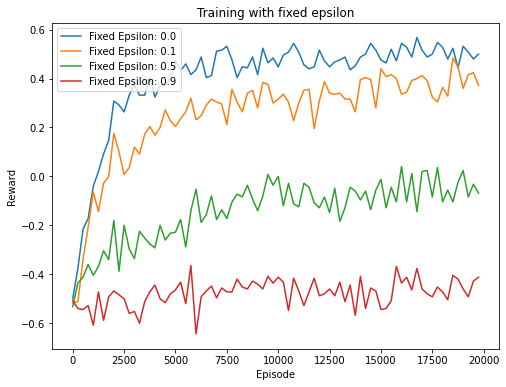

In [6]:
# Training with a fixed epsilon (Question 1)

# reset sed to reproduce the results
set_seed()

# RL Hyper-params
number_of_episodes = 20000

# Environment
environment = TictactoeEnv()

# plots 
fig,ax = plt.subplots(figsize=(8, 6))
plt.title("Training with fixed epsilon")

# List of epsilons to try 
epsilons= [0.0, 0.1, 0.5, 0.9]

for epsilon in epsilons:
    # Train and get the rewards for a fixed epsilon 
    player_rl_agent, rewards, _, _ = train_rl_agent_qlearning(environment, number_of_episodes=number_of_episodes, optimal_level=0.5, epsilon=epsilon, test_episode=number_of_episodes)
    plot_rewards(number_of_episodes, rewards, ax, label=f"Fixed Epsilon: {epsilon}")


#### Decreasing exploration
##### Questions 2 & 3

100%|██████████| 20000/20000 [04:03<00:00, 82.12it/s] 


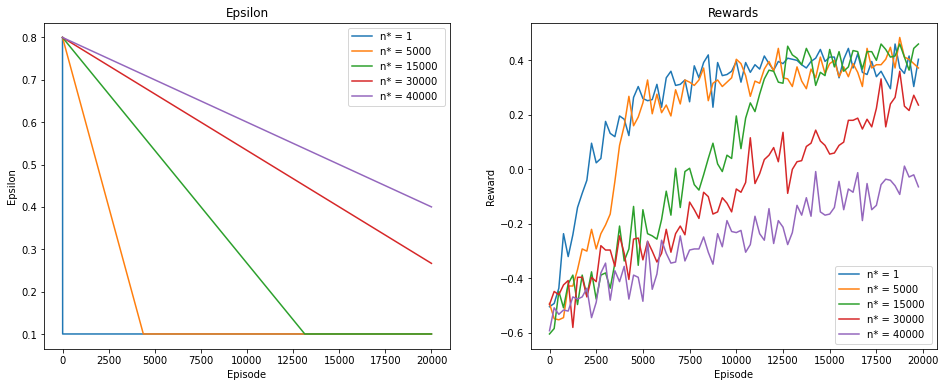

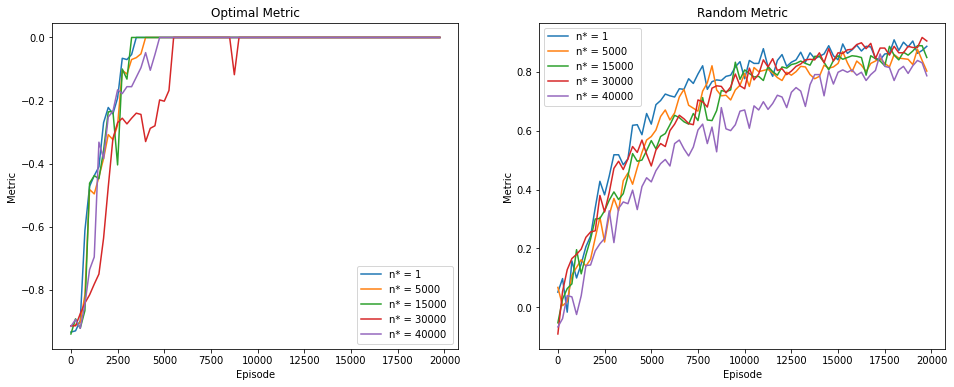

In [8]:
# Training with a monotonically decreasing epsilon (Question 2 and Question 3)

# reset seed to reproduce the results
set_seed()

# RL Hyper-params
number_of_episodes = 20000

epsilon_min, epsilon_max = 0.1, 0.8

# Environment
environment = TictactoeEnv()

# Plots
fig1, axes1 = plt.subplots(1, 2, figsize=(16, 6))
axes1[0].set_title("Epsilon")
axes1[1].set_title("Rewards")
fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
axes2[0].set_title("Optimal Metric")
axes2[1].set_title("Random Metric")

list_of_number_of_exploratory_games = [1, 5000, 15000, 30000, 40000]
#m_opt_epsilon_decreasing_q = {}
#m_rand_epsilon_decreasing_q  = {}

for number_of_exploratory_games in list_of_number_of_exploratory_games:
    # Train and get the rewards, M_opt, M_rand for a monotonically decreasing epsilon 
    epsilon = lambda n: max(epsilon_min, epsilon_max*(1-(n/number_of_exploratory_games)))
    player_rl_agent, rewards, m_opt, m_rand = train_rl_agent_qlearning(environment, number_of_episodes=number_of_episodes, optimal_level=0.5, epsilon=epsilon, test_episode=250)
    epsilon_list = [epsilon(n) for n in range(number_of_episodes)]
    
    plot_epsilon(number_of_episodes, epsilon_list, axes1[0], label = f"n* = {number_of_exploratory_games} ")
    plot_rewards(number_of_episodes, rewards, axes1[1], label = f"n* = {number_of_exploratory_games} ")
    plot_metrics(number_of_episodes, m_opt, axes2[0], label = f"n* = {number_of_exploratory_games} ")
    plot_metrics(number_of_episodes, m_rand, axes2[1], label = f"n* = {number_of_exploratory_games} ")
    
    #m_opt_epsilon_decreasing_q[number_of_exploratory_games] = m_opt
    #m_rand_epsilon_decreasing_q[number_of_exploratory_games] = m_rand

#### Good experts and bad experts
##### Question 4
Now that we have explored the effect of the (fixed/varying) epsilon on the training performance, we will explore the effect of the optimality of the teacher on the training policy. Specifically, would the RL agent train better if it trained while playing against an optimal policy or a random policy or somewhere in between?

100%|██████████| 20000/20000 [03:20<00:00, 99.86it/s] 


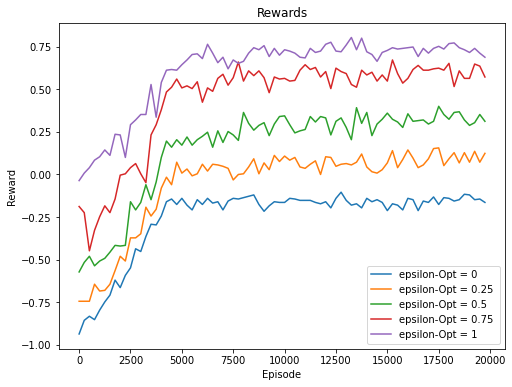

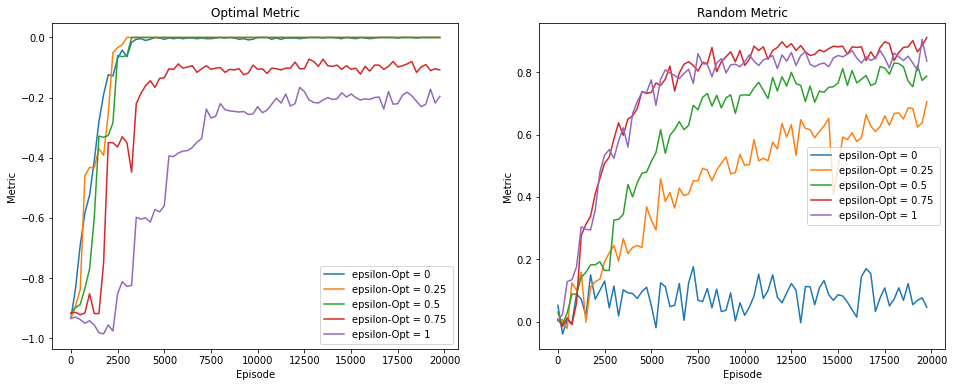

In [9]:
# Train with various Optimal level of the Agent for the optimal n* = 5000 (Question 4). 

# reset seed to reproduce the results
set_seed()

# RL Hyper-params
number_of_episodes = 20000
epsilon_min,epsilon_max = 0.1, 0.8
number_of_exploratory_games = 5000
epsilon = lambda n: max(epsilon_min, epsilon_max*(1-(n/number_of_exploratory_games)))

# Environment
environment = TictactoeEnv()

# Plot
fig,ax = plt.subplots(figsize=(8,6))
plt.title("Rewards")
fig, axes = plt.subplots(1,2,figsize=(16,6))
axes[0].set_title("Optimal Metric")
axes[1].set_title("Random Metric")

list_of_optimal_levels = [0,0.25,0.5,0.75,1]
m_opt_various_optimality_q = {}
m_rand_various_optimality_q  = {}
for optimal_level in list_of_optimal_levels:
    # Train and get the rewards, M_opt, M_rand for a different optimality levels of the teacher  
    player_rl_agent, rewards, m_opt, m_rand = train_rl_agent_qlearning(environment, number_of_episodes=number_of_episodes, optimal_level=optimal_level,epsilon=epsilon, test_episode=250)
    plot_rewards(number_of_episodes, rewards, ax, label = f"epsilon-Opt = {optimal_level} ")
    plot_metrics(number_of_episodes, m_opt, axes[0], label = f"epsilon-Opt = {optimal_level} ")
    plot_metrics(number_of_episodes, m_rand, axes[1], label = f"epsilon-Opt = {optimal_level} ")
    m_opt_various_optimality_q[optimal_level] = m_opt
    m_rand_various_optimality_q[optimal_level] = m_rand

##### Question 5

In [18]:
max_m_opt = max([m_opt_values[-1] for m_opt_values in m_opt_various_optimality_q.values()])
argmax_m_opt = [k for k,v in m_opt_various_optimality_q.items() if v[-1] == max_m_opt]
max_m_rand = max([m_rand_values[-1] for m_rand_values in m_rand_various_optimality_q.values()])
argmax_m_rand = [k for k,v in m_rand_various_optimality_q.items() if v[-1] == max_m_rand]

print(f'The highest value of Mopt that we could get achieve after {number_of_episodes} games is {max_m_opt}, for ε_opt = {argmax_m_opt}.')
print(f'The highest value of Mrand that we could get achieve after {number_of_episodes} games is {max_m_rand}, for ε_opt = {argmax_m_rand}.')

The highest value of Mopt that we could get achieve after 20000 games is 0.0, for ε_opt = [0, 0.25, 0.5].
The highest value of Mrand that we could get achieve after 20000 games is 0.912, for ε_opt = [0.75].


### Learning by self-practice
Now that we have deeply explored the performance the effect of the epsilon (exploration probability) and the optimality level of teacher. It would be interresting to see weather the RL Agent can learn by playing against itself since this capability is highly valued when we don't know what the optimal policy is (very common in real-life problems). 

With that, we implemented a new training procedure, where the RL agent plays againt it self by choosing actions from and updating the values of the same Q-table.

In [19]:
def train_rl_agent_self_learning(environment: TictactoeEnv, number_of_episodes: int, epsilon:float, test_episode:int, verbose: bool = False):
    # Initialize the Rewards and Test Metrics
    metrics_opt = np.zeros(int(number_of_episodes/test_episode))
    metrics_rand = np.zeros(int(number_of_episodes/test_episode))

    # Instantiate the Players
    player_rl_agent_1 = RlAgent(epsilon=epsilon, player="X")
    player_rl_agent_2 = RlAgent(epsilon=epsilon, player="O")

    for episode in tqdm(range(number_of_episodes)):
        player_rl_agent_1.train()
        player_rl_agent_2.train()
        
        # Reset the Environment
        environment.reset()
        
        #Observe the Environment
        grid, _, _ = environment.observe()

        #Choose the players X,O
        rl_agent_1_character, rl_agent_2_character = choose_players(index = episode)
        player_rl_agent_1.player = rl_agent_1_character
        player_rl_agent_2.player = rl_agent_2_character
        
        # Give RL access to the board
        player_rl_agent_1.observe_state(grid)
        player_rl_agent_2.observe_state(grid)

        # Update nb of episode played
        player_rl_agent_1.update_nb_of_episode_played(episode) 
        player_rl_agent_2.update_nb_of_episode_played(episode) 

        # store backup diagram 
        player_1_states_actions_observed: List[Tuple[np.ndarray, int]] = []
        player_2_states_actions_observed: List[Tuple[np.ndarray, int]] = []
        
        for step in range(9):
            if environment.current_player == player_rl_agent_1.player:
                # get RL Reward for previous move
                player_1_reward = environment.reward(rl_agent_1_character)

                #RL current state and action
                player_rl_agent_1.observe_state(grid, store_state = True)
                player_1_state = grid
                player_1_action = player_rl_agent_1.act(grid)

                # store player 1 move
                player_1_states_actions_observed.append((player_1_state, player_1_action))

                # move player
                move = (int(player_1_action/3),player_1_action%3)

                if len(player_1_states_actions_observed)==2:
                    # get previous state, previous action
                    previous_state, previous_action = player_1_states_actions_observed.pop(0)

                    # update the q table
                    player_rl_agent_1.update_q_table(previous_state, previous_action, player_1_reward, player_1_state)
                    player_rl_agent_2.q_table = player_rl_agent_1.q_table
            else:
                # get RL Reward for previous move
                player_2_reward = environment.reward(rl_agent_2_character)

                #RL current state and action
                player_rl_agent_2.observe_state(grid)
                player_2_state = grid
                player_2_action = player_rl_agent_2.act(grid)

                #store player action
                player_2_states_actions_observed.append((player_2_state, player_2_action))

                # move player
                move = (int(player_2_action/3),player_2_action%3)


                if len(player_2_states_actions_observed)==2:
                    # get previous state, previous action
                    previous_state, previous_action = player_2_states_actions_observed.pop(0)

                    # update the q_table
                    player_rl_agent_2.update_q_table(previous_state, previous_action, player_2_reward, player_2_state)
                    player_rl_agent_1.q_table = player_rl_agent_2.q_table

            #Execute an action    
            grid, end, winner = environment.step(move, print_grid=False)


            if end:
                # get the current reward
                if environment.current_player == rl_agent_1_character:
                    # get the reward, state, action
                    player_2_reward = environment.reward(rl_agent_2_character)
                    player_2_state, player_2_action = player_2_states_actions_observed.pop(0)
                    # update the q table
                    player_rl_agent_2.update_q_table(player_2_state, player_2_action, player_2_reward, None)
                    player_rl_agent_1.q_table = player_rl_agent_2.q_table
                    
                    # get the reward, state and action
                    player_1_reward = environment.reward(rl_agent_1_character)
                    player_1_state, player_1_action = player_1_states_actions_observed.pop(0)
                    # update the q table
                    player_rl_agent_1.update_q_table(player_1_state, player_1_action, player_1_reward, None)
                    player_rl_agent_2.q_table = player_rl_agent_1.q_table
                
                else:
                    # get the reward, state and action
                    player_1_reward = environment.reward(rl_agent_1_character)
                    player_1_state, player_1_action = player_1_states_actions_observed.pop(0)
                    # update the q table
                    player_rl_agent_1.update_q_table(player_1_state, player_1_action, player_1_reward, None)
                    player_rl_agent_2.q_table = player_rl_agent_1.q_table

                    # get the reward, state, action
                    player_2_reward = environment.reward(rl_agent_2_character)
                    player_2_state, player_2_action = player_2_states_actions_observed.pop(0)
                    # update the q table
                    player_rl_agent_2.update_q_table(player_2_state, player_2_action, player_2_reward, None)
                    player_rl_agent_1.q_table = player_rl_agent_2.q_table
                    
                if verbose:
                    logger(winner, rl_agent_1_character, rl_agent_2_character)
                    environment.render()
                environment.reset()
                break
        
        if ((episode)%test_episode == 0):
            m_opt, m_rand = compute_metrics(environment, player_rl_agent_1, 500)
            metrics_opt[int(episode/test_episode)] = m_opt
            metrics_rand[int(episode/test_episode)] = m_rand
    return player_rl_agent_1, metrics_opt, metrics_rand   




##### Question 7
With that, we will proceed as before by evaluating the effect of fixed/varying epsilon on the self-learning training procedure by allowing the RL agent play against it self and updating the same Q-table.

100%|██████████| 20000/20000 [03:10<00:00, 105.23it/s]


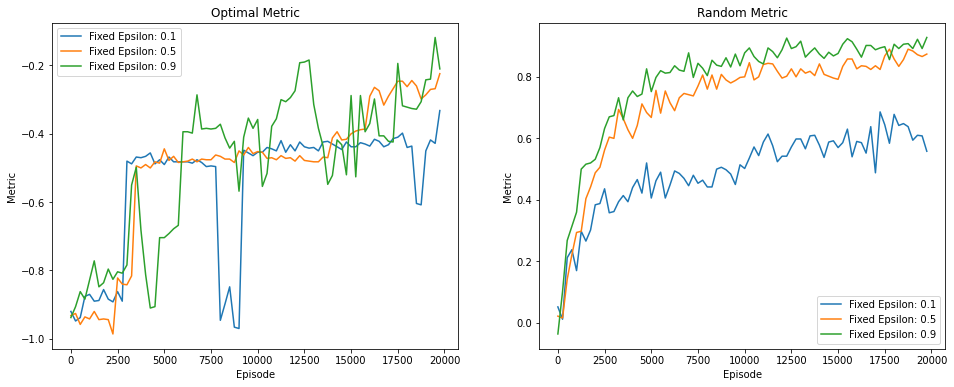

In [20]:
# Training by playing against it self with fixed epsilon (Question 7)

# reset sed to reproduce the results
set_seed()

# RL Hyper-params
number_of_episodes = 20000

# Environment
environment = TictactoeEnv()

# plots 
fig, axes = plt.subplots(1,2,figsize=(16,6))
axes[0].set_title("Optimal Metric")
axes[1].set_title("Random Metric")


list_of_epsilons = [0.1,0.5,0.9]

for epsilon in list_of_epsilons:
# Train and get the M_opt, and M_rand for a fixed epsilon
    player_rl_agent, m_opt, m_rand = train_rl_agent_self_learning(environment, number_of_episodes=number_of_episodes,epsilon=epsilon, test_episode=250)
    plot_metrics(number_of_episodes,m_opt, axes[0],label=f"Fixed Epsilon: {epsilon}")
    plot_metrics(number_of_episodes,m_rand, axes[1],label=f"Fixed Epsilon: {epsilon}")

##### Question 8

100%|██████████| 20000/20000 [03:18<00:00, 100.88it/s]


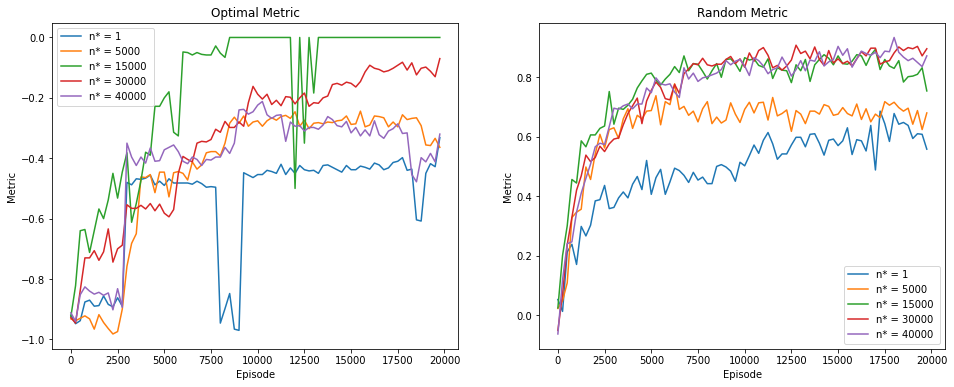

In [21]:
# Training by playing against it self with decreasing epsilon (Question 8)

# RL Hyper-params
number_of_episodes = 20000
epsilon_min,epsilon_max = 0.1, 0.8

# reset sed to reproduce the results
set_seed()

# Environment
environment = TictactoeEnv()

# plots 
fig, axes = plt.subplots(1,2,figsize=(16,6))
axes[0].set_title("Optimal Metric")
axes[1].set_title("Random Metric")

list_of_number_of_exploratory_games = [1,5000,15000,30000,40000]

# Define the best player agent 
m_opt_self_epsilon_decreasing_q = {}
m_rand_self_epsilon_decreasing_q = {}
players = {}
for number_of_exploratory_games in list_of_number_of_exploratory_games:
# Train and get the M_opt and M_rand for a number of exploratory games
    epsilon = lambda n: max(epsilon_min, epsilon_max*(1-(n/number_of_exploratory_games)))
    player_rl_agent, m_opt, m_rand = train_rl_agent_self_learning(environment, number_of_episodes=number_of_episodes,epsilon=epsilon, test_episode=250)

    plot_metrics(number_of_episodes,m_opt, axes[0],label= f"n* = {number_of_exploratory_games} ")
    plot_metrics(number_of_episodes,m_rand, axes[1],label= f"n* = {number_of_exploratory_games} ")
    m_opt_self_epsilon_decreasing_q[number_of_exploratory_games] = m_opt
    m_rand_self_epsilon_decreasing_q[number_of_exploratory_games] = m_rand
    players[number_of_exploratory_games] = player_rl_agent

##### Question 9

In [107]:
max_m_opt = max([m_opt_values[-1] for m_opt_values in m_opt_self_epsilon_decreasing_q.values()])
argmax_m_opt = [k for k,v in m_opt_self_epsilon_decreasing_q.items() if v[-1] == max_m_opt]
max_m_rand = max([m_rand_values[-1] for m_rand_values in m_rand_self_epsilon_decreasing_q.values()])
argmax_m_rand = [k for k,v in m_rand_self_epsilon_decreasing_q.items() if v[-1] == max_m_rand]

print(f'The highest value of Mopt that we could get achieve after {number_of_episodes} games is {max_m_opt}, for n* = {argmax_m_opt}.')
print(f'The highest value of Mrand that we could get achieve after {number_of_episodes} games is {max_m_rand}, for n* = {argmax_m_rand}.')

The highest value of Mopt that we could get achieve after 20000 games is 0.0, for n* = [15000].
The highest value of Mrand that we could get achieve after 20000 games is 0.896, for n* = [30000].


##### Question 10

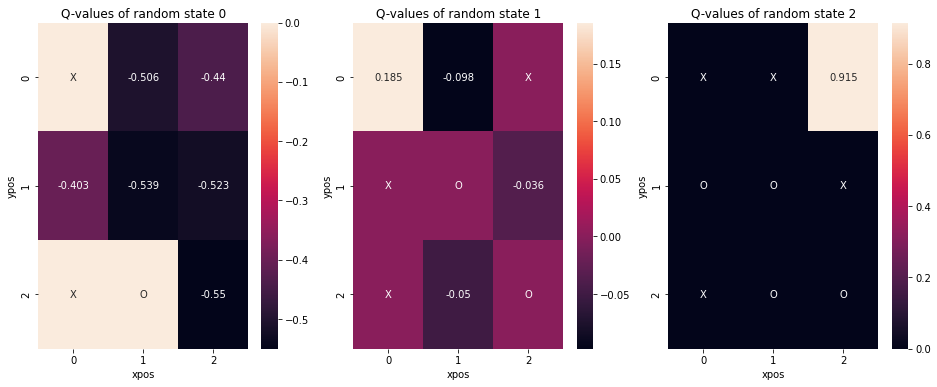

In [19]:
# get the best player agent for both metrics 
# (here the best Mopt agent had the best performance tradeoff with both metrics, so we can retrieve it with argmax_m_opt).
player_rl_agent = players[argmax_m_opt[0]]

# Visualize the heat map
number_of_visualized_states = 3
fig, ax = plt.subplots(ncols=3, figsize=(16,6))

for index in range(number_of_visualized_states):
    state = player_rl_agent.observed_states[randrange(len(player_rl_agent.observed_states))]
    state_key = player_rl_agent.get_state_key(state)
    q_values = player_rl_agent.q_table[state_key]
    q_values_reshaped = q_values.reshape((3,3))
    sns.heatmap(q_values_reshaped, annot = convert_value_to_play_character(state, q_values), ax=ax[index], fmt="")
    ax[index].set_title(f"Q-values of random state {index}")
    ax[index].set_xlabel("xpos")
    ax[index].set_ylabel("ypos")


## Deep Q-Learning

In [4]:
# A class that stores the current state, next_state, current_action
class Transition:
    def __init__(self, current_state: torch.Tensor, current_action: torch.Tensor, next_state:torch.Tensor, reward: torch.Tensor):
        self.current_state = current_state
        self.current_action = current_action
        self.next_state = next_state
        self.reward = reward
        

# A class that store the transitions     
class ReplayBuffer:
    def __init__(self,buffer_size)->None:
        self.memory = deque([],maxlen=buffer_size)

    def push(self, transition: Transition)->None:
        self.memory.append(transition)
    
    def sample(self, batch_size: int)->List[Transition]:
        return random.sample(self.memory, batch_size)
    
    def is_training_feasible(self, batch_size):
        return len(self.memory)>=batch_size

    def __len__(self):
        return len(self.memory)

In [5]:
## MODEL: Deep Q-Learning Model 
class DQN_model(nn.Module):
    def __init__(self,dimension_of_state_values, number_of_actions):
        super().__init__()
        self.fc1 = nn.Linear(dimension_of_state_values,128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128,number_of_actions)

    def forward(self,val):
        val = F.relu(self.fc1(val))
        val = F.relu(self.fc2(val))
        val = self.fc3(val)
        return val


In [6]:
# Utility functions

def get_training_data(training_transitions:List[Transition]):
    training_states: List[torch.Tensor] = []
    training_actions: List[torch.Tensor] = []
    training_rewards: List[torch.Tensor] = []
    training_next_states: List[torch.Tensor] = []
    non_final_states_indices: List[int] = []

    for index,transition in enumerate(training_transitions):
        training_states.append(transition.current_state)
        training_actions.append(tensor([transition.current_action]))
        training_rewards.append(tensor([transition.reward]))
        
        # Final/Non-final next state
        if transition.next_state is not None:
            training_next_states.append(transition.next_state)
            non_final_states_indices.append(index)
    
    training_states = torch.cat(training_states, dim=0)
    training_actions = torch.cat(training_actions).reshape(len(training_actions),1)
    training_rewards = torch.cat(training_rewards).reshape(len(training_rewards),1)
    
    if len(training_next_states) == 0:
        next_states = tensor([])
    else:    
        next_states = torch.cat(training_next_states, dim = 0)


    return training_states, training_actions, training_rewards, next_states, non_final_states_indices


def get_rl_state(board:np.ndarray, rl_player:str):
    flattened_board = board.flatten()
    state_x = (flattened_board==1).astype(int)
    state_o = (flattened_board==-1).astype(int)

    # form the state
    state = tensor([np.concatenate((state_x,state_o))]).float() if rl_player == 'X' else tensor([np.concatenate((state_o,state_x))]).float()
    return state

def check_if_feasible_move(current_state: torch.Tensor, action):
    current_state_rl_value = current_state[:,action].item()
    current_state_optimal_value = current_state[:,action+9].item()
    return current_state_rl_value == current_state_optimal_value == 0


In [7]:
class DeepRLAgent:
    def __init__(self, player: str, epsilon: float, discount_factor: float = 0.99, learning_rate:float = 5e-4)->None:
        # Choose the Player (X,O)
        self.player = player
        
        # DQN Hyperparams
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate

        # Initialize the network model, target model
        self.dqn_model:DQN_model = DQN_model(dimension_of_state_values=18, number_of_actions=9)
        
        self.target_model = DQN_model(dimension_of_state_values=18, number_of_actions=9)
        self.target_model.load_state_dict(self.dqn_model.state_dict())
        self.target_model.eval()

        # initialize the optimizer        
        self.optimizer = optim.Adam(self.dqn_model.parameters(), lr = self.learning_rate)

        # Test flag
        self.is_test = False
        
        # current episode number
        self.current_episode = 0

        # store observed states for visualization later on
        self.observed_states:List[torch.Tensor] = []

    def test(self):
        # set to test behavior
        self.is_test = True
    
    def train(self):
        # set to train behavior
        self.is_test = False

    def get_epsilon(self):
        if isinstance(self.epsilon, Callable):
            return self.epsilon(self.current_episode)
        else:
            return self.epsilon

    def update_nb_of_episode_played(self, episode_number):
        #update current episode number
        self.current_episode = episode_number

    def act(self, state, store_state = False):
        # act based on epsilon greedy strategy
        if store_state:
            self.observed_states.append(state)
            
        if self.is_test:
            return self._get_best_action(state)
        else:
            if random.uniform(0,1) < self.get_epsilon():
                return self._get_random_action(state)
            else:
                return self._get_best_action(state)
            
    def update_dqn_model(self, training_data:List[Transition]):
        # update the model using Adam Optimizer
        current_states, current_actions, current_rewards, non_terminal_next_states, non_terminal_indices = get_training_data(training_data)

        # get the Q_values(s,a) 
        current_q_values: torch.Tensor = self.dqn_model(current_states).gather(1,current_actions)

        # get next max_a Q_values(s,a*)
        next_q_values: torch.Tensor = torch.zeros(current_actions.shape[0])
        if len(non_terminal_next_states)>0:
            next_q_values[non_terminal_indices]= self.target_model(non_terminal_next_states).max(1)[0].detach()
        next_q_values = next_q_values.reshape(current_actions.shape[0],1)

        # Error function 
        expected_q_values = current_rewards + self.discount_factor*next_q_values

        # devise the error function
        criterion = nn.SmoothL1Loss()
        loss: torch.Tensor = criterion(current_q_values, expected_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        
        for param in self.dqn_model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        #print("loss: ", loss.item())
        return loss
    
    def update_target_model(self):
        # update the target network after C steps
        self.target_model.load_state_dict(self.dqn_model.state_dict())

    def synchronize_dqn_model(self, model:nn.Module):
        self.dqn_model.load_state_dict(model.state_dict())

    def _get_random_action(self, state):
        # get random action
        available_actions = get_available_actions(state)
        return random.choice(available_actions)

    def _get_best_action(self, state: torch.Tensor):
        # get best action
        q_values:torch.Tensor = self.dqn_model(state)
        best_action = q_values.max(1)[1]
        return best_action.item()

def get_available_actions(state: torch.Tensor):
    available_actions:List[int] = []
    for index in range(9):
        if state[:,index].item() == state[:,index].item() == 0:
            available_actions.append(index)
    return available_actions

In [8]:
def train_deep_learning_agent_with_buffer(environment: TictactoeEnv, number_of_episodes: int, optimal_level:float, epsilon:float, memory_buffer_size:int, batch_size:int = 64,target_model_update:int = 500, plot_every:int= 250,test_episode:int = 250, verbose: bool = False):
    # Initialize the Rewards and Test Metrics
    rewards = np.zeros(number_of_episodes)
    loss_values: List[float] = []
    average_loss_values: List[float] = []
    metrics_opt = np.zeros(int(number_of_episodes/test_episode))
    metrics_rand = np.zeros(int(number_of_episodes/test_episode))

    # Instantiate the Players
    player_optimal = OptimalPlayer(epsilon=optimal_level, player="X")
    player_rl_agent = DeepRLAgent(epsilon=epsilon, player="O")

    # create a memory buffer
    memory = ReplayBuffer(memory_buffer_size)
    
    for episode in tqdm(range(number_of_episodes)):
        player_rl_agent.train()
        
        # Reset the Environment
        environment.reset()
        
        #Observe the Environment
        grid, _, _ = environment.observe()

        #Choose the players X,O
        optimal_player_character,rl_player_character = choose_players(index = episode)
        player_optimal.player = optimal_player_character
        player_rl_agent.player = rl_player_character
        
        # store backup diagram 
        states_actions_observed: List[Tuple[torch.Tensor, int]] = []
        
        # update the current episode playeed for the RL Agent
        player_rl_agent.update_nb_of_episode_played(episode)

        for step in range(9):
            if environment.current_player == player_optimal.player:
                move = player_optimal.act(grid)
                grid, end, winner = environment.step(move, print_grid=False)
            
            else:
                # Observe current state and execute desired action
                reward = environment.reward(rl_player_character)

                rl_state = get_rl_state(grid, player_rl_agent.player)
                rl_action = player_rl_agent.act(rl_state)
                move = (int(rl_action/3),rl_action%3)

                # if the RL Agent played an illegal move
                if not check_if_feasible_move(rl_state, rl_action):
                    rewards[episode] = -1
                    memory.push(Transition(current_state=rl_state, current_action=rl_action, reward=-1, next_state=None))
                    break
                
                
                # store the states and actions observed
                states_actions_observed.append((rl_state, rl_action))

                if len(states_actions_observed) == 2:
                    # Store the interaction in a replay buffer
                    previous_state, previous_action = states_actions_observed.pop(0)
                    memory.push(Transition(current_state=previous_state, current_action=previous_action, reward=reward, next_state=rl_state))

                if memory.is_training_feasible(batch_size):
                    training_data = memory.sample(batch_size)
                    loss: torch.Tensor = player_rl_agent.update_dqn_model(training_data)
                    loss_values.append(loss.item())
                
                # Step in the environment 
                grid, end, winner = environment.step(move, print_grid=False)

            if end:
                reward = environment.reward(rl_player_character)
                rewards[episode] = reward
                
                memory.push(Transition(current_state=rl_state, current_action=rl_action, reward=reward, next_state=None))
       
                if verbose:
                    logger(winner, optimal_player_character, rl_player_character)
                    environment.render()
                environment.reset()
                break
        
        if ((episode+1)%target_model_update) == 0:
            player_rl_agent.update_target_model()
        
        if ((episode+1)%plot_every) == 0:
            average_loss_values.append(np.mean(np.array(loss_values)))
            loss_values = []     

        if ((episode)%test_episode == 0):
            m_opt, m_rand = compute_metrics_dqn(environment, player_rl_agent, 500)
            metrics_opt[int(episode/test_episode)] = m_opt
            metrics_rand[int(episode/test_episode)] = m_rand

    return player_rl_agent, rewards, average_loss_values, metrics_opt, metrics_rand 



In [9]:
def train_deep_learning_agent_without_buffer(environment: TictactoeEnv, number_of_episodes: int, optimal_level:float, epsilon:float, target_model_update:int = 500, plot_every:int= 250, verbose: bool = False):
    # Initialize the Rewards and Test Metrics
    rewards = np.zeros(number_of_episodes)
    loss_values: List[float] = []
    average_loss_values: List[float] = []

    # Instantiate the Players
    player_optimal = OptimalPlayer(epsilon=optimal_level, player="X")
    player_rl_agent = DeepRLAgent(epsilon=epsilon, player="O")
    
    for episode in tqdm(range(number_of_episodes)):
        player_rl_agent.train()
        
        # Reset the Environment
        environment.reset()
        
        #Observe the Environment
        grid, _, _ = environment.observe()

        #Choose the players X,O
        optimal_player_character,rl_player_character = choose_players(index = episode)
        player_optimal.player = optimal_player_character
        player_rl_agent.player = rl_player_character
        
        # store backup diagram 
        states_actions_observed: List[Tuple[torch.Tensor, int]] = []
        
        for step in range(9):
            if environment.current_player == player_optimal.player:
                move = player_optimal.act(grid)
                grid, end, winner = environment.step(move, print_grid=False)
            
            else:
                # observe reward from previous action
                reward = environment.reward(rl_player_character)

                # Observe current state and execute desired action
                rl_state = get_rl_state(grid, player_rl_agent.player)
                rl_action = player_rl_agent.act(rl_state)
                move = (int(rl_action/3),rl_action%3)

                # if the RL Agent played an illegal move
                if not check_if_feasible_move(rl_state, rl_action):
                    rewards[episode] = -1
                    # set the rewards and update the DQN Model 
                    loss = player_rl_agent.update_dqn_model([Transition(current_state=rl_state, current_action=rl_action, reward=-1, next_state=None)])
                    loss_values.append(loss.item())
                    break


                states_actions_observed.append((rl_state, rl_action))
                if len(states_actions_observed) == 2:
                    #pop from the backup diagram and update the DQN Model
                    previous_state, previous_action = states_actions_observed.pop(0)
                    loss = player_rl_agent.update_dqn_model([Transition(current_state=previous_state, current_action=previous_action, reward=reward, next_state=rl_state)])
                    loss_values.append(loss.item())
                                
                # Step in the environment and observe the reward
                grid, end, winner = environment.step(move, print_grid=False)

            if end:
                reward = environment.reward(rl_player_character)
                rewards[episode] = reward
                
                loss = player_rl_agent.update_dqn_model([Transition(current_state=rl_state, current_action=rl_action, reward=reward, next_state=None)])
                loss_values.append(loss.item())
                
                if verbose:
                    logger(winner, optimal_player_character, rl_player_character)
                    environment.render()
                environment.reset()
                break
        
        if ((episode+1)%target_model_update) == 0:
            player_rl_agent.update_target_model()
        
        if ((episode+1)%plot_every) == 0:
            average_loss_values.append(np.mean(np.array(loss_values)))
            loss_values = []     

    return player_rl_agent, rewards, average_loss_values 



In [10]:
def compute_metrics_dqn(environment: TictactoeEnv, player_rl_agent:DeepRLAgent, number_of_episodes:int, verbose: bool = False):
    player_rl_agent.test()
    
    number_of_rl_wins, number_of_optimal_wins = evaluate_rl_agent_dqn(environment, player_rl_agent,number_of_episodes, 0.0, verbose)
    M_opt = (number_of_rl_wins -  number_of_optimal_wins)/number_of_episodes

    number_of_rl_wins, number_of_optimal_wins = evaluate_rl_agent_dqn(environment, player_rl_agent,number_of_episodes, 1.0, verbose)
    M_rand = (number_of_rl_wins -  number_of_optimal_wins)/number_of_episodes

    return M_opt, M_rand

def evaluate_rl_agent_dqn(environment: TictactoeEnv, player_rl_agent:DeepRLAgent, number_of_episodes:int, optimal_level : float, verbose: bool = False):
    # Instantiate the Players
    player_optimal = OptimalPlayer(epsilon=optimal_level, player="X")
    player_rl_agent.player = "O"

    number_of_rl_wins = 0
    number_of_optimal_wins = 0
    for episode in range(number_of_episodes):
        # Reset the Environment
        environment.reset()
        
        #Observe the Environment
        grid, _, _ = environment.observe()

        #Choose the players X,O
        optimal_player_character, rl_player_character = choose_players(index = episode)
        player_optimal.player = optimal_player_character
        player_rl_agent.player = rl_player_character
                
        for step in range(9):
            if environment.current_player == player_optimal.player:
                move = player_optimal.act(grid)
            else:
                rl_state = get_rl_state(grid, player_rl_agent.player)
                rl_action = player_rl_agent.act(rl_state)
                if not check_if_feasible_move(rl_state, rl_action):
                    number_of_optimal_wins +=1
                    break
                move = (int(rl_action/3),rl_action%3)
        
            grid, end, winner = environment.step(move, print_grid=False)
            
            if end:
                if winner == optimal_player_character:
                    number_of_optimal_wins +=1
                    
                if winner == rl_player_character:
                    number_of_rl_wins += 1
                    
                if verbose:
                    logger(winner, optimal_player_character, rl_player_character)
                    environment.render()
                environment.reset()
                break
        

    return number_of_rl_wins, number_of_optimal_wins   

### Learning from experts
##### Question 11

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:22<00:00, 98.61it/s]


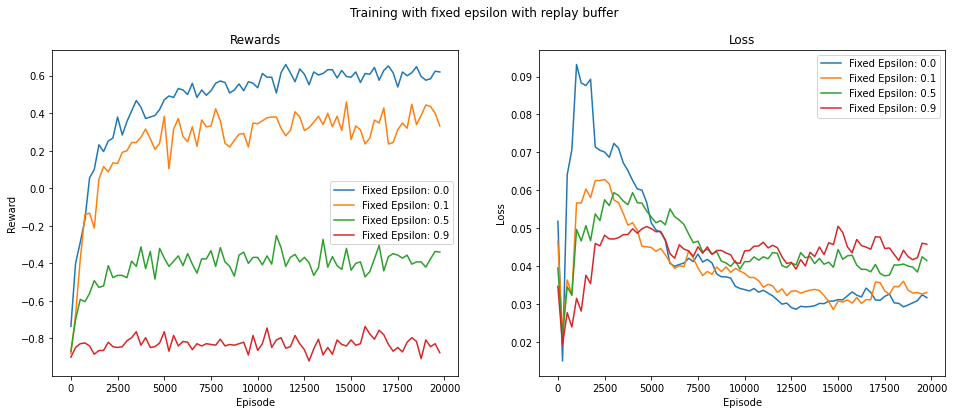

In [44]:
# Training with a fixed epsilon (Question 11)

# Environment
environment = TictactoeEnv()

# reset sed to reproduce the results
set_seed()

# RL Hyper params
number_of_episodes=20000
memory_buffer_size = 10000
optimal_level = 0.5

# plots 
fig, axes = plt.subplots(1,2,figsize=(16,6))
axes[0].set_title("Rewards")
axes[1].set_title("Loss")
plt.suptitle("Training with fixed epsilon with replay buffer")

# List of epsilons to try 
epsilons= [0.0, 0.1, 0.5, 0.9]

for epsilon in epsilons:
    # Train and get the rewards for a fixed epsilon 
    player_rl_agent, rewards, loss,_,_ = train_deep_learning_agent_with_buffer(environment, number_of_episodes, optimal_level, epsilon, memory_buffer_size, test_episode=number_of_episodes)
    plot_rewards(number_of_episodes, rewards, axes[0], label=f"Fixed Epsilon: {epsilon}")
    plot_loss(number_of_episodes, loss, axes[1], label=f"Fixed Epsilon: {epsilon}")

##### Question 12

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [02:22<00:00, 140.69it/s]


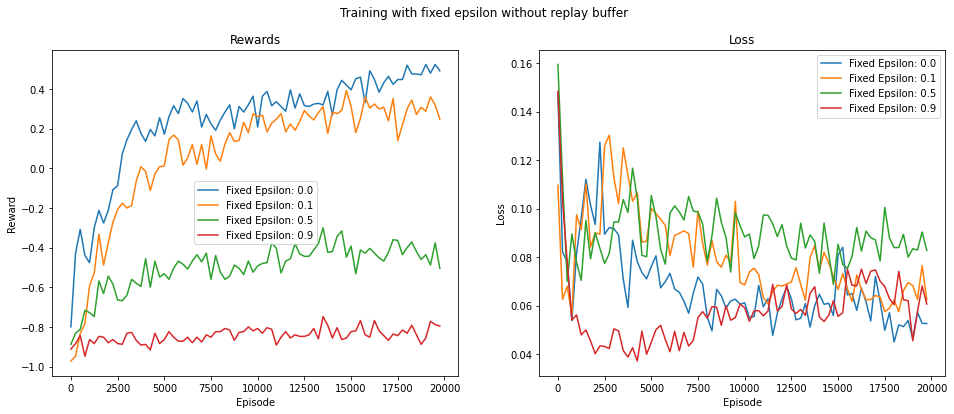

In [45]:
# Training with a fixed epsilon (Question 12) but without a replay buffer

# Environment
environment = TictactoeEnv()

# reset sed to reproduce the results
set_seed()

# RL Hyper params
number_of_episodes=20000
memory_buffer_size = 1
optimal_level = 0.5

# plots 
fig, axes = plt.subplots(1,2,figsize=(16,6))
axes[0].set_title("Rewards")
axes[1].set_title("Loss")
plt.suptitle("Training with fixed epsilon without replay buffer")

# List of epsilons to try 
epsilons= [0.0, 0.1, 0.5, 0.9]

for epsilon in epsilons:
    # Train and get the rewards for a fixed epsilon 
    player_rl_agent, rewards, loss = train_deep_learning_agent_without_buffer(environment, number_of_episodes, optimal_level, epsilon)
    plot_rewards(number_of_episodes, rewards, axes[0], label=f"Fixed Epsilon: {epsilon}")
    plot_loss(number_of_episodes, loss, axes[1], label=f"Fixed Epsilon: {epsilon}")

##### Question 13

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [20:13<00:00, 16.48it/s]


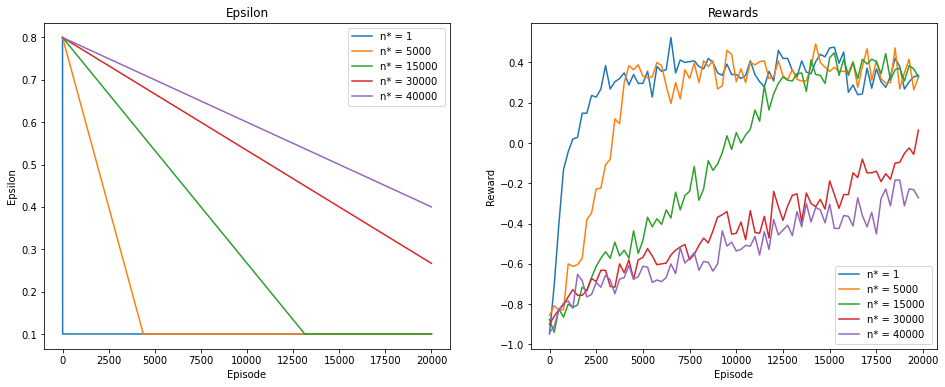

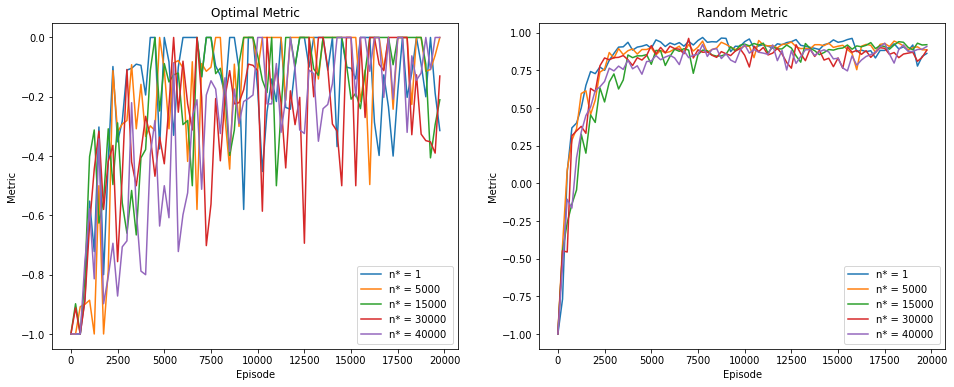

In [26]:
# Training with a monotonically decreasing epsilon (Question 13)

# RL Hyper-params
number_of_episodes = 20000
memory_buffer_size = 10000
epsilon_min, epsilon_max = 0.1, 0.8
optimal_level = 0.5

# reset sed to reproduce the results
set_seed()

# Environment
environment = TictactoeEnv()

# Plots
fig1, axes1 = plt.subplots(1, 2, figsize=(16, 6))
axes1[0].set_title("Epsilon")
axes1[1].set_title("Rewards")
fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
axes2[0].set_title("Optimal Metric")
axes2[1].set_title("Random Metric")

# TODO: FIND smoothest plot
list_of_number_of_exploratory_games = [1, 5000, 15000, 30000, 40000]
 
#m_opt_epsilon_decreasing_dqn = {}
#m_rand_epsilon_decreasing_dqn = {}

for number_of_exploratory_games in list_of_number_of_exploratory_games:
    # Train and get the rewards, M_opt, M_rand for a decreasing monotinically epsilon 
    epsilon = lambda n: max(epsilon_min, epsilon_max*(1-(n/number_of_exploratory_games)))
    player_rl_agent, rewards,_, m_opt, m_rand = train_deep_learning_agent_with_buffer(environment, number_of_episodes=number_of_episodes, optimal_level=0.5, epsilon=epsilon,memory_buffer_size=memory_buffer_size, test_episode=250)
    epsilon_list = [epsilon(n) for n in range(number_of_episodes)]
    plot_epsilon(number_of_episodes, epsilon_list, axes1[0], label = f"n* = {number_of_exploratory_games} ")
    plot_rewards(number_of_episodes, rewards, axes1[1], label = f"n* = {number_of_exploratory_games} ")
    plot_metrics(number_of_episodes, m_opt, axes2[0], label = f"n* = {number_of_exploratory_games} ")
    plot_metrics(number_of_episodes, m_rand, axes2[1], label = f"n* = {number_of_exploratory_games} ")

    #m_opt_epsilon_decreasing_dqn[number_of_exploratory_games] = m_opt
    #m_rand_epsilon_decreasing_dqn[number_of_exploratory_games] = m_rand


##### Question 14

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [10:46<00:00, 30.95it/s]


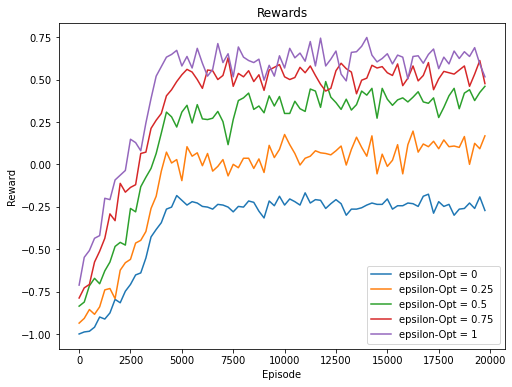

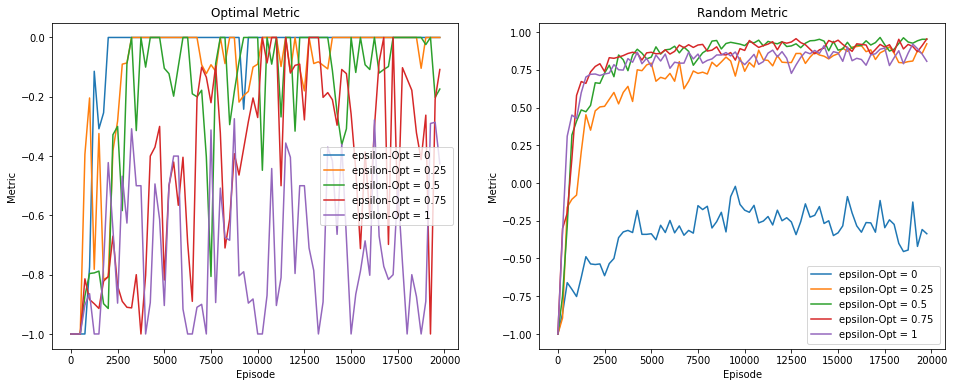

In [27]:
# Train with various Optimal level of the Agent for the optimal n* = 5000 (Question 14). 

# RL Hyper-params
number_of_episodes = 20000
memory_buffer_size = 10000
epsilon_min,epsilon_max = 0.1, 0.8

# reset sed to reproduce the results
set_seed()

# Put best n* for smoothest plot
number_of_exploratory_games = 5000
epsilon = lambda n: max(epsilon_min, epsilon_max*(1-(n/number_of_exploratory_games)))

# Environment
environment = TictactoeEnv()

# Plot
fig,ax = plt.subplots(figsize=(8,6))
plt.title("Rewards")

# Optimal Metric, Random Metric
fig, axes = plt.subplots(1,2,figsize=(16,6))
axes[0].set_title("Optimal Metric")
axes[1].set_title("Random Metric")

list_of_optimal_levels = [0,0.25,0.5,0.75,1]
m_opt_various_optimality_dqn = {}
m_rand_various_optimality_dqn = {}
for optimal_level in list_of_optimal_levels:
    # Train and get the rewards, M_opt, M_rand for a different optimality levels of the teacher  
    player_rl_agent, rewards,_, m_opt, m_rand = train_deep_learning_agent_with_buffer(environment, number_of_episodes=number_of_episodes, optimal_level=optimal_level, epsilon=epsilon,memory_buffer_size=memory_buffer_size, test_episode=250)
    plot_rewards(number_of_episodes, rewards, ax, label = f"epsilon-Opt = {optimal_level} ")
    plot_metrics(number_of_episodes, m_opt, axes[0], label = f"epsilon-Opt = {optimal_level} ")
    plot_metrics(number_of_episodes, m_rand, axes[1], label = f"epsilon-Opt = {optimal_level} ")
    m_opt_various_optimality_dqn[optimal_level] = m_opt
    m_rand_various_optimality_dqn[optimal_level] = m_rand

##### Question 15

In [28]:
max_m_opt = max([m_opt_values[-1] for m_opt_values in m_opt_various_optimality_dqn.values()])
argmax_m_opt = [k for k,v in m_opt_various_optimality_dqn.items() if v[-1] == max_m_opt]
max_m_rand = max([m_rand_values[-1] for m_rand_values in m_rand_various_optimality_dqn.values()])
argmax_m_rand = [k for k,v in m_rand_various_optimality_dqn.items() if v[-1] == max_m_rand]

print(f'The highest value of Mopt that we could get achieve after {number_of_episodes} games is {max_m_opt}, for ε_opt = {argmax_m_opt}.')
print(f'The highest value of Mrand that we could get achieve after {number_of_episodes} games is {max_m_rand}, for ε_opt = {argmax_m_rand}.')

The highest value of Mopt that we could get achieve after 20000 games is 0.0, for ε_opt = [0, 0.25, 0.5, 0.75].
The highest value of Mrand that we could get achieve after 20000 games is 0.964, for ε_opt = [0.5].


### Learning by self-practice

In [11]:
def train_deep_learning_agent_by_self_learning(environment: TictactoeEnv, number_of_episodes: int,  epsilon:float, memory_buffer_size:int, batch_size:int = 64,target_model_update:int = 500, plot_every:int= 250,test_episode:int = 250, verbose: bool = False):
    # Initialize the Rewards and Test Metrics
    loss_values: List[float] = []
    average_loss_values: List[float] = []
    metrics_opt = np.zeros(int(number_of_episodes/test_episode))
    metrics_rand = np.zeros(int(number_of_episodes/test_episode))

    # Instantiate the Players
    player_rl_agent_1 = DeepRLAgent(epsilon=epsilon, player="X")
    player_rl_agent_2 = DeepRLAgent(epsilon=epsilon, player="O")

    # create a memory buffer
    memory = ReplayBuffer(memory_buffer_size)
    
    for episode in tqdm(range(number_of_episodes)):
        player_rl_agent_1.train()
        player_rl_agent_2.train()

        # Reset the Environment
        environment.reset()
        
        #Observe the Environment
        grid, _, _ = environment.observe()

        #Choose the players X,O
        rl_player_1_character,rl_player_2_character = choose_players(index = episode)
        player_rl_agent_1.player = rl_player_1_character
        player_rl_agent_2.player = rl_player_2_character
        
        # store backup diagram 
        states_actions_observed_player_1: List[Tuple[torch.Tensor, int]] = []
        states_actions_observed_player_2: List[Tuple[torch.Tensor, int]] = []

        # update the current episode playeed for the RL Agent
        player_rl_agent_1.update_nb_of_episode_played(episode)
        player_rl_agent_2.update_nb_of_episode_played(episode)

        for step in range(9):
            if environment.current_player == player_rl_agent_1.player:
                reward = environment.reward(rl_player_1_character)

                player_1_rl_state = get_rl_state(grid, player_rl_agent_1.player)
                player_1_rl_action = player_rl_agent_1.act(player_1_rl_state, store_state=True)
                move = (int(player_1_rl_action/3),player_1_rl_action%3)

                # if the RL Agent played an illegal move
                if not check_if_feasible_move(player_1_rl_state, player_1_rl_action):
                    memory.push(Transition(current_state=player_1_rl_state, current_action=player_1_rl_action, reward=-1, next_state=None))
                    break

                # store the states and actions observed
                states_actions_observed_player_1.append((player_1_rl_state, player_1_rl_action))

                if len(states_actions_observed_player_1) == 2:
                    # Store the interaction in a replay buffer
                    player_1_previous_state, player_1_previous_action = states_actions_observed_player_1.pop(0)
                    memory.push(Transition(current_state=player_1_previous_state, current_action=player_1_previous_action, reward=reward, next_state=player_1_rl_state))

                if memory.is_training_feasible(batch_size):
                    training_data = memory.sample(batch_size)
                    loss: torch.Tensor = player_rl_agent_1.update_dqn_model(training_data)
                    loss_values.append(loss.item())            

                    # synchronize the models between the two players
                    player_rl_agent_2.synchronize_dqn_model(player_rl_agent_1.dqn_model)
            else:
                # Observe current state and execute desired action
                reward = environment.reward(rl_player_2_character)

                player_2_rl_state = get_rl_state(grid, player_rl_agent_2.player)
                player_2_rl_action = player_rl_agent_2.act(player_2_rl_state)
                move = (int(player_2_rl_action/3),player_2_rl_action%3)

                # if the RL Agent played an illegal move
                if not check_if_feasible_move(player_2_rl_state, player_2_rl_action):
                    memory.push(Transition(current_state=player_2_rl_state, current_action=player_2_rl_action, reward=-1, next_state=None))
                    break
                
                # store the states and actions observed
                states_actions_observed_player_2.append((player_2_rl_state, player_2_rl_action))

                if len(states_actions_observed_player_2) == 2:
                    # Store the interaction in a replay buffer
                    player_2_previous_state, player_2_previous_action = states_actions_observed_player_2.pop(0)
                    memory.push(Transition(current_state=player_2_previous_state, current_action=player_2_previous_action, reward=reward, next_state=player_2_rl_state))

                if memory.is_training_feasible(batch_size):
                    training_data = memory.sample(batch_size)
                    loss: torch.Tensor = player_rl_agent_2.update_dqn_model(training_data)
                    loss_values.append(loss.item())

                    # synchronize the models between the two players
                    player_rl_agent_1.synchronize_dqn_model(player_rl_agent_2.dqn_model)

            # Step in the environment 
            grid, end, winner = environment.step(move, print_grid=False)

            if end:
                # store last player 1 interaction
                reward_player_1 = environment.reward(rl_player_1_character)
                player_1_rl_state, player_1_rl_action = states_actions_observed_player_1.pop(0)
                memory.push(Transition(current_state=player_1_rl_state, current_action=player_1_rl_action, reward=reward_player_1, next_state=None))

                # store last player 2 interaction
                reward_player_2 = environment.reward(rl_player_2_character)
                player_2_rl_state, player_2_rl_action = states_actions_observed_player_2.pop(0)
                memory.push(Transition(current_state=player_2_rl_state, current_action=player_2_rl_action, reward=reward_player_2, next_state=None))

                if verbose:
                    logger(winner, rl_player_1_character, rl_player_2_character)
                    environment.render()
                environment.reset()
                break
        
        if ((episode+1)%target_model_update) == 0:
            player_rl_agent_1.update_target_model()
            player_rl_agent_2.update_target_model()
        
        if ((episode+1)%plot_every) == 0:
            average_loss_values.append(np.mean(np.array(loss_values)))
            loss_values = []     

        if ((episode)%test_episode == 0):
            m_opt, m_rand = compute_metrics_dqn(environment, player_rl_agent_1, 500)
            metrics_opt[int(episode/test_episode)] = m_opt
            metrics_rand[int(episode/test_episode)] = m_rand

    return player_rl_agent_1, average_loss_values, metrics_opt, metrics_rand 



##### Question 16

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [10:47<00:00, 30.89it/s]


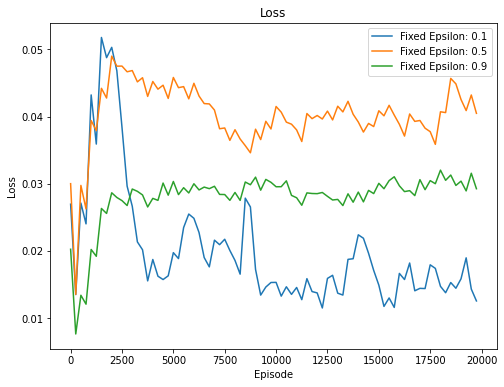

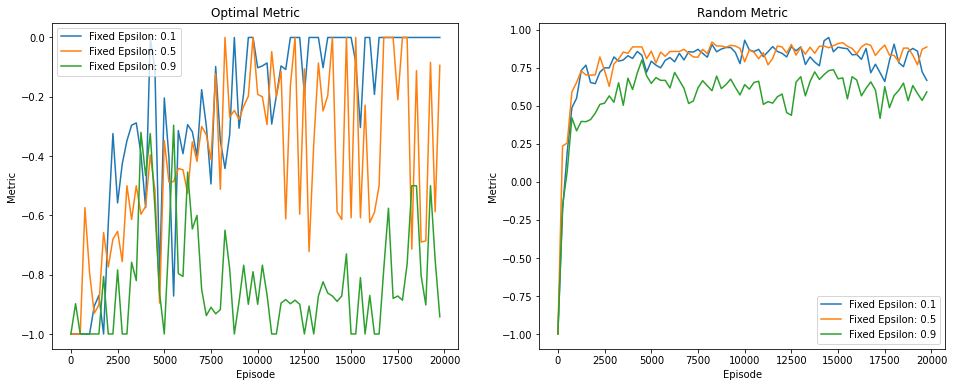

In [79]:
# Training by playing against it self with fixed epsilon (Question 16)

# RL Hyper-params
number_of_episodes = 20000

# reset sed to reproduce the results
set_seed()

# Environment
environment = TictactoeEnv()

fig,ax = plt.subplots(figsize=(8,6))
plt.title("Loss")

# plots 
fig, axes = plt.subplots(1,2,figsize=(16,6))
axes[0].set_title("Optimal Metric")
axes[1].set_title("Random Metric")


list_of_epsilons = [0.1,0.5,0.9]

for epsilon in list_of_epsilons:
# Train and get the M_opt, and M_rand for a fixed epsilon
    player_rl_agent,loss, m_opt, m_rand = train_deep_learning_agent_by_self_learning(environment = environment, number_of_episodes=number_of_episodes,epsilon=epsilon,memory_buffer_size=10000, test_episode=250 )
    plot_loss(number_of_episodes, loss, ax, label=f"Fixed Epsilon: {epsilon}")
    plot_metrics(number_of_episodes,m_opt, axes[0],label=f"Fixed Epsilon: {epsilon}")
    plot_metrics(number_of_episodes,m_rand, axes[1],label=f"Fixed Epsilon: {epsilon}")

##### Question 17

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [10:58<00:00, 30.36it/s]


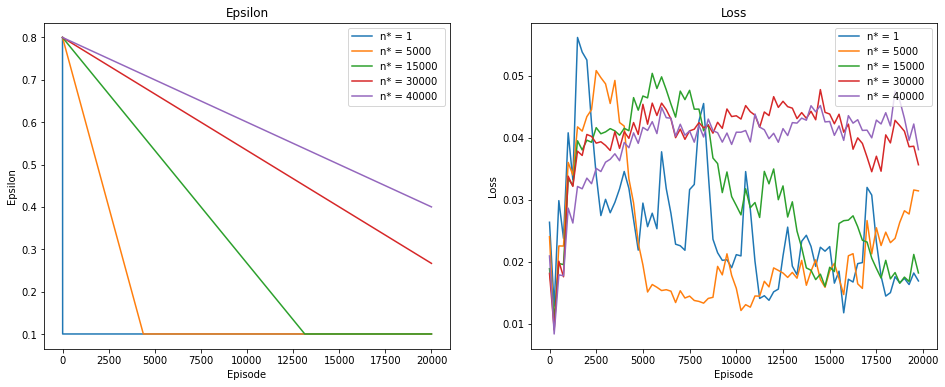

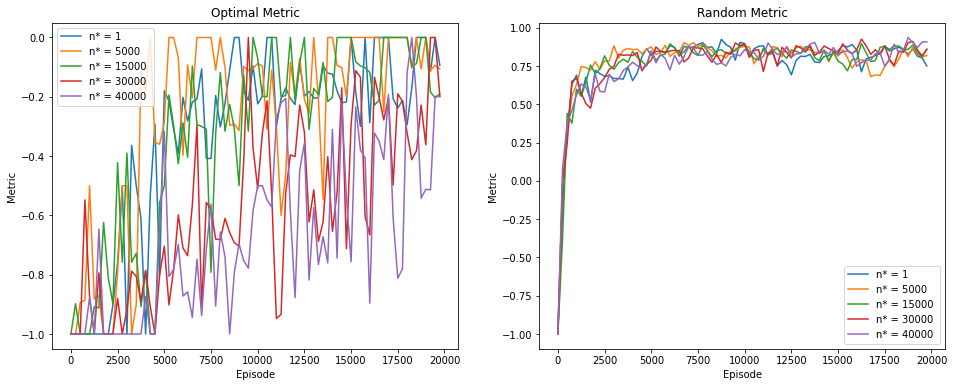

In [15]:
# Training with a monotonically decreasing epsilon (Question 17)

# RL Hyper-params
number_of_episodes = 20000
memory_buffer_size = 10000
epsilon_min, epsilon_max = 0.1, 0.8

# reset sed to reproduce the results
set_seed()

# Environment
environment = TictactoeEnv()

# Plots
fig1, axes1 = plt.subplots(1, 2, figsize=(16, 6))
axes1[0].set_title("Epsilon")
axes1[1].set_title("Loss")

fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
axes2[0].set_title("Optimal Metric")
axes2[1].set_title("Random Metric")

list_of_number_of_exploratory_games = [1, 5000, 15000, 30000, 40000]

# Define the best player agent 
m_opt_self_epsilon_decreasing_dqn:Dict[int, float] = {}
m_rand_self_epsilon_decreasing_dqn:Dict[int, float] = {}
players:Dict[int,DeepRLAgent] = {}
 
for number_of_exploratory_games in list_of_number_of_exploratory_games:
    # Train and get the rewards, M_opt, M_rand for a decreasing monotinically epsilon 
    epsilon = lambda n: max(epsilon_min, epsilon_max*(1-(n/number_of_exploratory_games)))
    player_rl_agent,loss, m_opt, m_rand = train_deep_learning_agent_by_self_learning(environment = environment, number_of_episodes=number_of_episodes,epsilon=epsilon,memory_buffer_size=memory_buffer_size, test_episode=250 )
    epsilon_list = [epsilon(n) for n in range(number_of_episodes)]
    plot_epsilon(number_of_episodes, epsilon_list, axes1[0], label = f"n* = {number_of_exploratory_games} ")
    plot_loss(number_of_episodes, loss, axes1[1], label = f"n* = {number_of_exploratory_games} ")
    plot_metrics(number_of_episodes, m_opt, axes2[0], label = f"n* = {number_of_exploratory_games} ")
    plot_metrics(number_of_episodes, m_rand, axes2[1], label = f"n* = {number_of_exploratory_games} ")
    
    m_opt_self_epsilon_decreasing_dqn[number_of_exploratory_games] = m_opt
    m_rand_self_epsilon_decreasing_dqn[number_of_exploratory_games] = m_rand
    players[number_of_exploratory_games] = player_rl_agent


##### Question 18

In [49]:
max_m_opt = max([m_opt_values[-1] for m_opt_values in m_opt_self_epsilon_decreasing_dqn.values()])
argmax_m_opt = [k for k,v in m_opt_self_epsilon_decreasing_dqn.items() if v[-1] == max_m_opt]
max_m_rand = max([m_rand_values[-1] for m_rand_values in m_rand_self_epsilon_decreasing_dqn.values()])
argmax_m_rand = [k for k,v in m_rand_self_epsilon_decreasing_dqn.items() if v[-1] == max_m_rand]

print(f'The highest value of Mopt that we could get achieve after {number_of_episodes} games is {max_m_opt}, for n* = {argmax_m_opt}.')
print(f'The highest value of Mrand that we could get achieve after {number_of_episodes} games is {max_m_rand}, for n* = {argmax_m_rand}.')

The highest value of Mopt that we could get achieve after 20000 games is 0.0, for n* = [1, 5000, 15000, 30000, 40000].
The highest value of Mrand that we could get achieve after 20000 games is 0.936, for n* = [40000].


##### Question 19

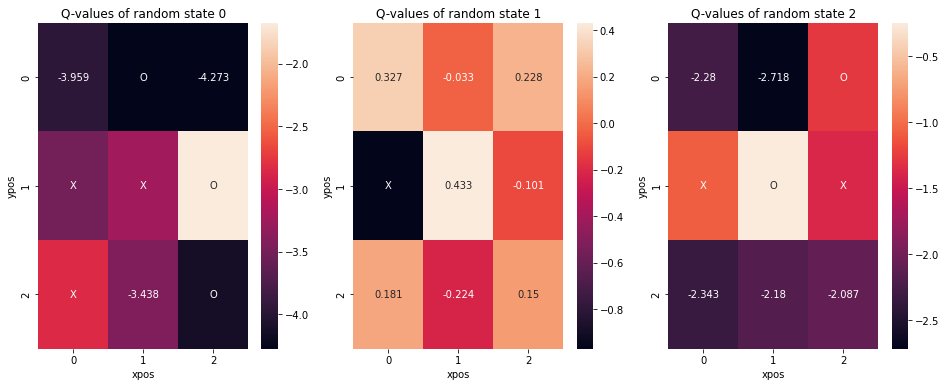

In [77]:
# get the best player agent for both metrics 
# (here we retrieve the best agent in the Mrand metric since all got a perfect Mopt).
player_rl_agent = players[argmax_m_rand[0]]

# Visualize the heat map
number_of_visualized_states = 3
fig, ax = plt.subplots(ncols=3, figsize=(16,6))

for index in range(number_of_visualized_states):
    state = player_rl_agent.observed_states[randrange(len(player_rl_agent.observed_states))]
    # unflatten the state and assign the correct play character (X or O)
    state_player1 = state.cpu().detach().numpy()[0][0:9].reshape((3,3))
    state_player2 = state.cpu().detach().numpy()[0][9:18].reshape((3,3))
    if np.sum(state_player1) > np.sum(state_player2):
        state_player2 *= -1
    else: 
        state_player1 *= -1
    state_reshaped = state_player1 + state_player2

    q_values = player_rl_agent.dqn_model(state).cpu().detach().numpy()[0]
    q_values_reshaped = q_values.reshape((3,3))

    sns.heatmap(q_values_reshaped, annot = convert_value_to_play_character(state_reshaped, q_values), ax=ax[index], fmt="")
    ax[index].set_title(f"Q-values of random state {index}")
    ax[index].set_xlabel("xpos")
    ax[index].set_ylabel("ypos")


### Comparing $Q$-Learning with Deep $Q$-Learning
##### Question 20

In [102]:
def get_highest_final_metric_values(results:Dict[int,np.ndarray]):
    max_value = float('-inf')
    best_scores_evolution = []
    for value in results.values():
        if value[-1]>max_value:
            max_value = value[-1]
            best_scores_evolution = value
    return max_value, best_scores_evolution

def get_training_time(m_opt_metrics_evolution: np.ndarray, m_rand_metrics_evolution: np.ndarray, highest_m_opt_value: float, highest_m_rand_value: float, calculated_every: int = 250):
    # Get 80% of final performance from initial performance
    threshold_m_opt = 0.8*(highest_m_opt_value - m_opt_metrics_evolution[0]) + m_opt_metrics_evolution[0]
    threshold_m_rand = 0.8*(highest_m_rand_value - m_rand_metrics_evolution[0]) + m_rand_metrics_evolution[0]
    # Training time will be taken as the worst training time of each metric. Add 1 to account for first 250 games at index 0.
    return (max(np.argmax(m_opt_metrics_evolution >= threshold_m_opt), np.argmax(m_rand_metrics_evolution >= threshold_m_rand)) + 1) * calculated_every
    

In [103]:
print("-----------------------Q-LEARNING METRICS----------------")

# Q-learning agent against teacher with varying optimality

max_m_opt_against_teacher, best_scores_evolution_mopt_against_teacher = get_highest_final_metric_values(m_opt_various_optimality_q)
max_m_rand_against_teacher, best_scores_evolution_mrand_against_teacher = get_highest_final_metric_values(m_rand_various_optimality_q)
q_learning_against_teacher_time = get_training_time(best_scores_evolution_mopt_against_teacher, best_scores_evolution_mrand_against_teacher, max_m_opt_against_teacher, max_m_rand_against_teacher, calculated_every = 250)

print("Max Mopt Q-learning against teacher with varying optimality: ", max_m_opt_against_teacher)
print("Max Mrand Q-learning against teacher with varying optimality: ", max_m_rand_against_teacher)
print("Training Time Q-learning against teacher with varying optimality: ", q_learning_against_teacher_time)

# Q-learning agent against itself
max_m_opt_against_self, best_scores_evolution_mopt_against_self = get_highest_final_metric_values(m_opt_self_epsilon_decreasing_q)
max_m_rand_against_self, best_scores_evolution_mrand_against_self = get_highest_final_metric_values(m_rand_self_epsilon_decreasing_q)
q_learning_against_self_time = get_training_time(best_scores_evolution_mopt_against_self, best_scores_evolution_mrand_against_self, max_m_opt_against_self, max_m_rand_against_self, calculated_every = 250)

print("Max Mopt Q-learning against itself: ", max_m_opt_against_self)
print("Max Mrand Q-learning against itself: ", max_m_rand_against_self)
print("Training Time Q-learning against itself: ", q_learning_against_self_time)

-----------------------Q-LEARNING METRICS----------------
Max Mopt Q-learning against teacher with varying optimality:  0.0
Max Mrand Q-learning against teacher with varying optimality:  0.912
Training Time Q-learning against teacher with varying optimality:  4750
Max Mopt Q-learning against itself:  0.0
Max Mrand Q-learning against itself:  0.896
Training Time Q-learning against itself:  5500


In [ ]:
print("-----------------------DQN METRICS----------------")

# DQN agent against teacher with varying optimality

max_m_opt_against_teacher, best_scores_evolution_mopt_against_teacher = get_highest_final_metric_values(m_opt_various_optimality_dqn)
max_m_rand_against_teacher, best_scores_evolution_mrand_against_teacher = get_highest_final_metric_values(m_rand_various_optimality_dqn)
dqn_learning_against_teacher_time = get_training_time(best_scores_evolution_mopt_against_teacher, best_scores_evolution_mrand_against_teacher, max_m_opt_against_teacher, max_m_rand_against_teacher, calculated_every = 250)

print("Max Mopt DQN against teacher with varying optimality: ", max_m_opt_against_teacher)
print("Max Mrand DQN against teacher with varying optimality: ", max_m_rand_against_teacher)
print("Training Time DQN against teacher with varying optimality: ", dqn_learning_against_optimal_time)

# DQN agent againts itself
max_m_opt_against_self, best_scores_evolution_mopt_against_self = get_highest_final_metric_values(m_opt_self_epsilon_decreasing_dqn)
max_m_rand_against_self, best_scores_evolution_mrand_against_self = get_highest_final_metric_values(m_rand_self_epsilon_decreasing_dqn)
dqn_learning_against_self_time = get_training_time(best_scores_evolution_mopt_against_self, best_scores_evolution_mrand_against_self, max_m_opt_against_self, max_m_rand_against_self, calculated_every = 250)

print("Max Mopt DQN against itself: ", max_m_opt_against_self)
print("Max Mrand DQN against itself: ", max_m_rand_against_self)
print("Training Time DQN against itself: ", dqn_learning_against_self_time)

### TODO:
2. Add new graphs in overleaf, new values, new heatmap, new heatmap explanation, change plot captions, remove questions, remove extraplot
5. Control+F: "TODO" and remove all pending TODOs
